In [740]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [741]:
import ReactiveMP.messageout

In [742]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [893]:
### find order
delay_y, delay_u, delay_e = 3, 3, 3
poly_order = 2
order_h = delay_e + 1

output__ = ϕ(randn(sum([delay_y, delay_u, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

41

In [598]:

function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (y, u, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([y; u; h[2:end]])
    end 
end

const phi_ = phi()

LoadError: invalid redefinition of constant phi_

In [772]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order, seed)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), obs_prec*diageye(h_order)))}
    w  = randomvar()
#     h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
#     z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], seed)}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ dot(ẑ[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

narmax (generic function with 1 method)

In [773]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10, seed=10, 
                          progress=true)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, h_order, full_order, seed,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginals!(z, MvNormalMeanPrecision(randn(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    p = ProgressMeter.Progress(vmp_its)
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
        if progress
            ProgressMeter.next!(p)
        end
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [774]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

## cascade dataset

In [775]:
df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

output_trn = y_train
output_val = y_val
input_trn = input_trn
input_val = input_val

1024-element Vector{Float64}:
 -1.8238110623262187
 -1.8007910489176124
 -1.7828010384388628
 -1.768201029934708
 -1.754401021896534
 -1.7376010121109313
 -1.7139009983062414
 -1.6790009779778163
 -1.6296009492034838
 -1.5629009103523104
 -1.4776008606670765
 -1.3736008000895348
 -1.2524007294933992
  ⋮
 -1.5194008850145886
 -1.664000969240671
 -1.781401037623396
 -1.8702210893589466
 -1.9305611245055705
 -1.964391144210746
 -1.9751211504607173
 -1.9672511458766284
 -1.9459411334640568
 -1.916491116310128
 -1.8838010972689758
 -1.8519510787171036

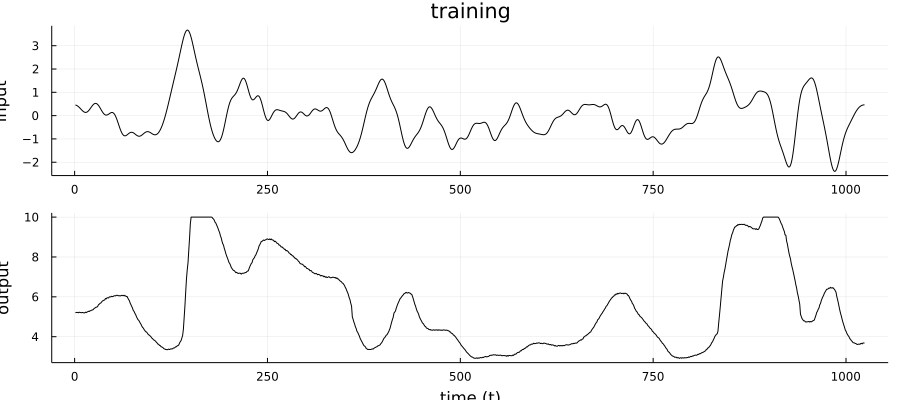

In [776]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

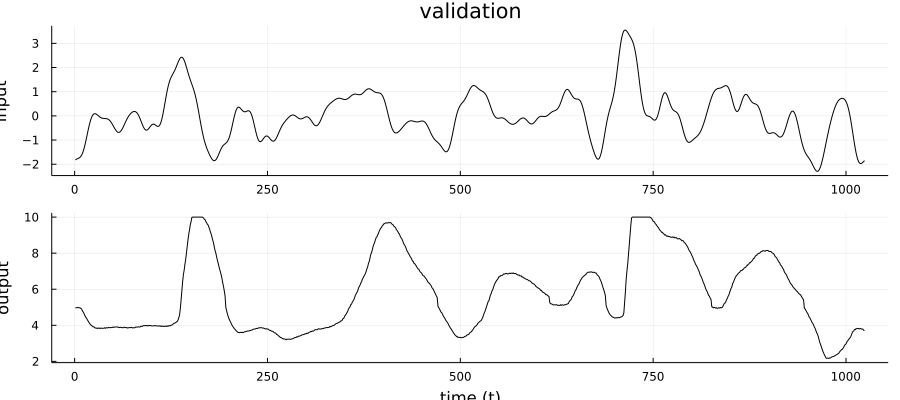

In [777]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## silverbox dataset

In [761]:

# df = DataFrame(CSV.File("../datasets/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# # Select input and output signals
# input = df[:,:V1]
# output = df[:,:V2]

# # Time horizon
# T = length(input);

# # normalization
# input = (input .- mean(input))/std(input)
# output = (output .- mean(output))/std(output);

In [762]:
# # Select training set
# trn = collect(40101:131072)
# input_trn = input[trn]
# output_trn = output[trn]
# T_trn = length(trn);

# # Select validation set
# val = 101:40100
# input_val = input[val]
# output_val = output[val]
# T_val = length(val);

In [763]:
# # Plot every n-th time-point to avoid figure size exploding
# n = 100
# ix = 1:n:T_trn

# # Plot training signals
# p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
# p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

In [764]:
# n = 1
# ix = 1:n:1024

# # Plot validation signals
# p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
# p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

### prepare training/test sets 

In [831]:
train_size = 1000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [766]:
include("../helpers/ar_extension.jl")

In [767]:
include("../helpers/nonlinear_node.jl")

In [768]:
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_silverbox_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");

In [898]:
coefs_mean = zeros(full_order); 
coefs_precision = diageye(full_order)
coefs_precision[1:8, 1:8] = 1e6*diageye(8)
# coefs_precision[36:end, 36:end] = 1e6*diageye(6)
# coefs_precision

8×8 Matrix{Float64}:
 1.0e6  0.0    0.0    0.0    0.0    0.0    0.0    0.0
 0.0    1.0e6  0.0    0.0    0.0    0.0    0.0    0.0
 0.0    0.0    1.0e6  0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    1.0e6  0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    1.0e6  0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    1.0e6  0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0    1.0e6  0.0
 0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0e6

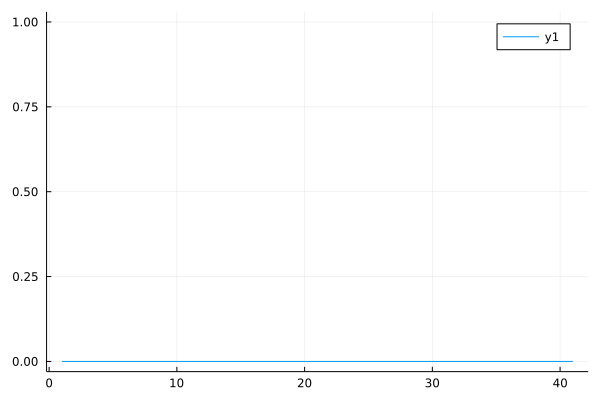

In [836]:
plot(coefs_mean)

In [899]:
sampling_seed = 1
fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(zeros(order_h), diageye(order_h)),
                                                       w_prior=(1e4, 1.0), 
                                                       η_prior=(coefs_mean, coefs_precision),
                                                       τ_prior=(1e2, 1.0), vmp_its=100, seed=sampling_seed);



Progress: 100%|█████████████████████████████████████████| Time: 0:04:56


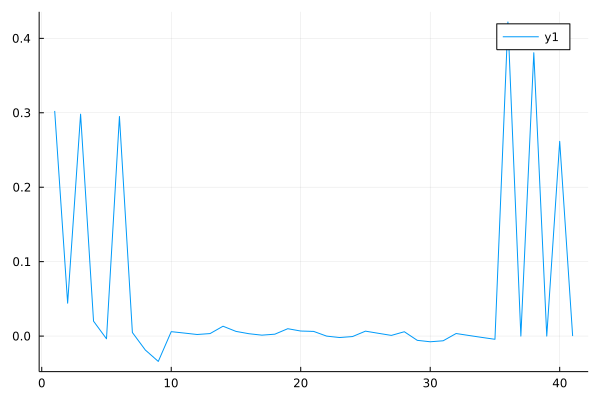

In [885]:
plot(mean(η_))

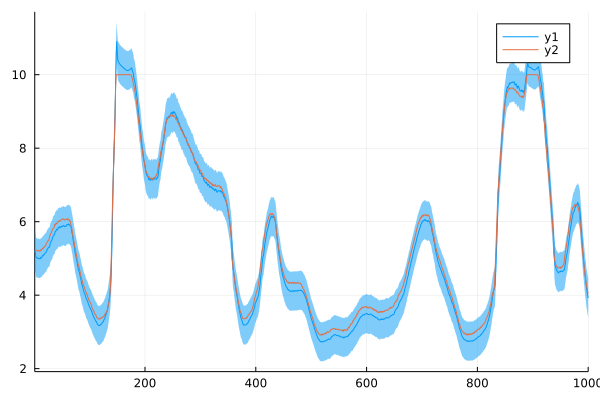

In [886]:
mfrom, mto = 1, 1000
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

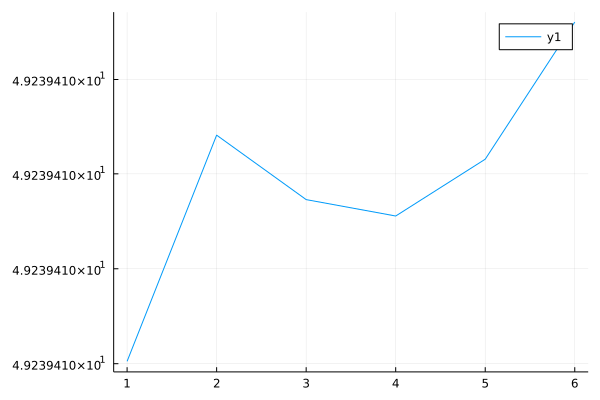

GKS: Possible loss of precision in routine SET_WINDOW


In [887]:
plot(fe_[5:end])

In [843]:
# JLD.save("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld", "η_", η_, "τ_", τ_, "w_", w_, "h_", h_, "fe_", fe_)

In [844]:
mean(τ_)

95.87889428660564

In [845]:
mean(w_)

9986.130086009944

In [846]:
mean(η_)

41-element Vector{Float64}:
  0.30249513408271106
  0.044168993008546556
  0.2981478223072723
  0.02004801375116921
 -0.0036329529065375534
  0.29499952467203777
  0.004802455311053394
 -0.01874344165927332
 -0.03405239219270964
  0.005953546160420212
  0.00407079195807885
  0.0021289725107914406
  0.00337514286063023
  ⋮
 -0.007637214673399434
 -0.006308395515898729
  0.0034506886259004542
  0.0007761081175884938
 -0.0018169591757260667
 -0.004307020137974011
  0.42196798059157475
 -2.01948563053366e-5
  0.3806852188257111
 -2.3390919139931817e-5
  0.261649446475558
 -2.425489462539368e-6

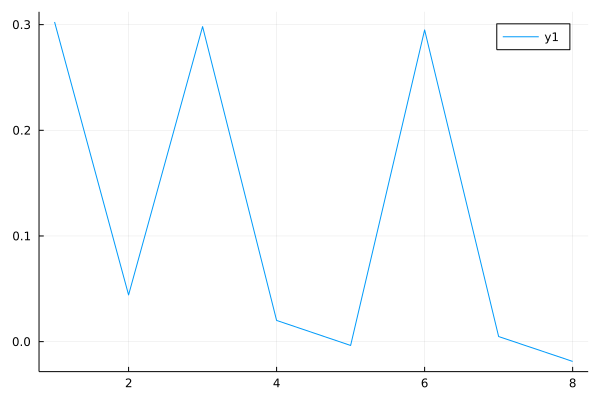

In [847]:
plot(mean(η_)[1:8])

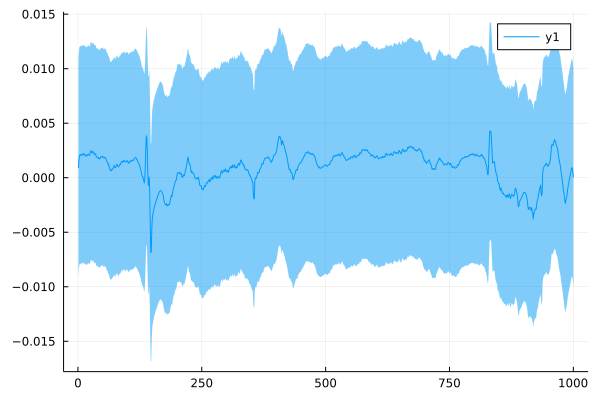

In [848]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction 

In [849]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [850]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, 42))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [851]:
τ_ = GammaShapeRate(shape(τ_), rate(τ_))

GammaShapeRate{Float64}(a=600.0, b=6.257894445533051)

In [894]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    fe_, h_post, θ_post, w_post, η_post, τ_post, _, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


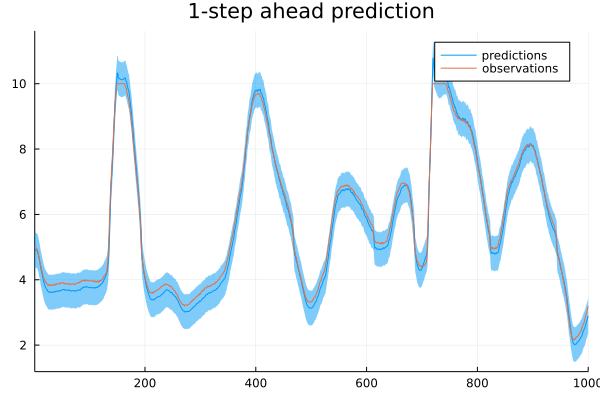

In [895]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

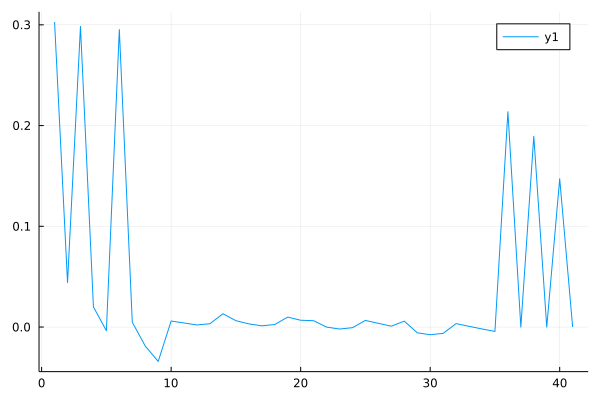

In [897]:
plot(mean(η_))

In [896]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.1787198093155361

In [855]:
# naive simulation setting

In [828]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
ProgressMeter.@showprogress for i in 1:length(Y_test)
    _, h_post, θ_post, w_post, η_post, τ_post, _, y_out_post = narmax_inference([simulated_Y[i]], [simulated_X[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                                 h_prior=(mean(h_prior), precision(h_prior)),
                                                                                 w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                 η_prior=(mean(η_prior), precision(η_prior)),
                                                                                 τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    
    h_prior = h_post[end]
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


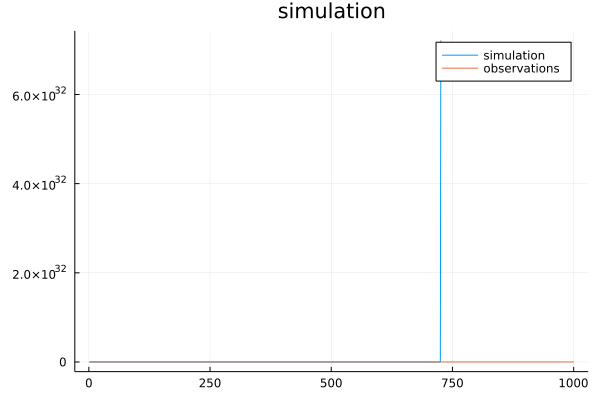

In [900]:
from, to = 1, 1000
plot(simulated_Y[from:to],  ribbon=simulated_Y_cov[from:to], label="simulation")
# plot!(first.(U_test[from:to]), label="controls")
plot!(Y_test[from:to], title="simulation", label="observations")

In [857]:
RMSE = sqrt(mean((simulated_Y[from:to] .- Y_test[from:to]).^2))

5.490747354317862

In [860]:
using Optim

In [861]:
melu(x) = clamp(x, convert(Float64, tiny), Inf)
Base.Float64(x::HugeNumber) = convert(Float64, x)

In [878]:
function loss_function(params)
    params_η = params[1:full_order]
    params_w = params[full_order+1:full_order+2]
    paramw_τ = params[full_order+3:end]
    
    h_prior = h_[end]
    w_prior = w_
    τ_prior = τ_
    η_prior = η_

    simulated_X = [X_test[1]]
    simulated_Y = [Y_test[1]]
    simulated_Y_cov = [0.0]
    
    for i in 1:length(Y_test)
        _, h_post, θ_post, w_post, η_post, τ_post, _, y_out_post = narmax_inference([simulated_Y[i]], [simulated_X[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                                     h_prior=(mean(h_prior), precision(h_prior)),
                                                                                     w_prior=melu.(params_w), 
                                                                                     η_prior=(params_η, diageye(full_order)),
                                                                                     τ_prior=melu.(paramw_τ), vmp_its=10, seed=10, progress=false);

        h_prior = h_post[end]
        η_prior = η_post
        τ_prior = τ_post
        w_prior = w_post

        push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
        pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], full_order=full_order, h_order=order_h)

        push!(simulated_Y, mean(pred_sim))
        push!(simulated_Y_cov, var(pred_sim))

    end
    
    RMSE = sqrt(mean((simulated_Y[from:to] .- Y_test[from:to]).^2))
end

loss_function (generic function with 1 method)

In [884]:
params_opt = randn(45)

res = optimize(loss_function, params_opt, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 100, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(loss_function), Float64}, Float64, 12})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:760
[0m  (::Type{T})([91m::VectorizationBase.Double{T}[39m) where T<:Union{Float16, Float32, Float64, VectorizationBase.Vec{var"#s33", var"#s32"} where {var"#s33", var"#s32"<:Union{Float16, Float32, Float64}}, VectorizationBase.VecUnroll{var"#s31", var"#s30", var"#s29", V} where {var"#s31", var"#s30", var"#s29"<:Union{Float16, Float32, Float64}, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{var"#s30", var"#s29"}}}} at /Users/apodusenko/.julia/packages/VectorizationBase/xtnDY/src/special/double.jl:84
[0m  ...